In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import itertools as itr
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTEN

C:\Users\Moustapha\AppData\Local\Temp\ipykernel_8932\2543586406.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data=pd.read_csv('data.csv')


C:\Users\Moustapha\AppData\Local\Temp\ipykernel_8932\2127919575.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('data.csv')


In [167]:
columns=[]
for column in data:
    num_na=data[column].isna().sum()
    if(num_na>0):
        print(f'{column}: NA\'s={num_na}')
        columns.append(column)

cellularity: NA's=40
er_status_measured_by_ihc: NA's=23
neoplasm_histologic_grade: NA's=52
primary_tumor_laterality: NA's=76
mutation_count: NA's=31
3-gene_classifier_subtype: NA's=166
tumor_size: NA's=12
tumor_stage: NA's=395
death_from_cancer: NA's=1


In [ ]:

for column in columns:
    plt.figure() 
    data[column].hist()
    plt.xlabel(column)
    plt.title(f'Histogram of {column}')
    plt.show()  

#remove row where death_from_cancer=null


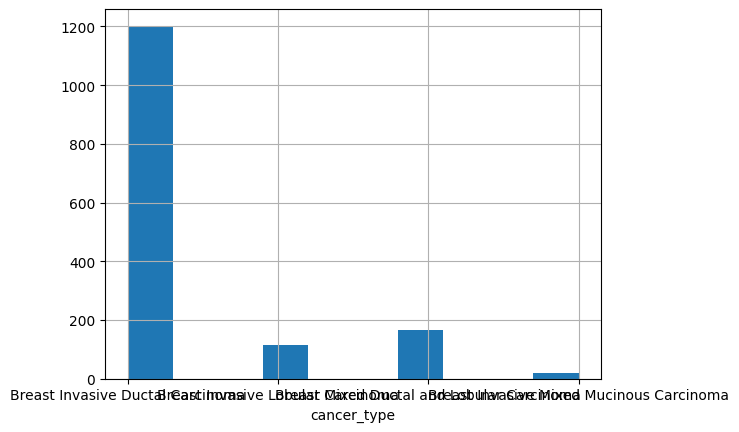

In [344]:
plt.figure()
data['cancer_type'].hist()
plt.xlabel('cancer_type')
plt.show()

In [ ]:
for column in data.select_dtypes(include=['object']).columns:
    category_counts = data[column].value_counts()
    
    print(f"\nColumn: {column}")
    print(category_counts)

In [204]:
def drop_single_class_columns(df):
  unique_value_counts = df.nunique()
  single_value_columns = unique_value_counts[unique_value_counts == 1].index
  return df.drop(columns=single_value_columns)


def remove_infrequent_categories(data, threshold=0.05):

  filtered_data = data.copy()
  categorical_columns = filtered_data.select_dtypes(include='object').columns
  categorical_columns = [column for column in categorical_columns if column.endswith('_mut')]


  for column in categorical_columns:
      filtered_data=filtered_data.loc[filtered_data[column].isin(filtered_data[column].value_counts().index[filtered_data[column].value_counts()/len(filtered_data) > threshold])]

  return filtered_data

def one_hot_encode_columns(df, columns):
  encoder = OneHotEncoder(sparse_output=False)

  encoded_data = encoder.fit_transform(df[columns])

  encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns))


  
  df_encoded = pd.concat([df.reset_index(drop=True),encoded_df.reset_index(drop=True)],axis=1)

  return  df_encoded.drop(columns,axis=1)

def data_preprocess(df):
  
  
  
  df = df.drop('patient_id', axis=1)
  df=df.drop('cohort',axis=1)
  
  
  numerical_columns = ['neoplasm_histologic_grade', 'mutation_count', 'tumor_size', 'tumor_stage']
  df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

  categorical_columns = ['er_status_measured_by_ihc', 'primary_tumor_laterality', '3-gene_classifier_subtype', 'death_from_cancer']
  for column in categorical_columns:
    most_frequent_class = df[column].mode()[0]
    df[column] = df[column].fillna(most_frequent_class)

  # label encoding for cellularity 40 nan values transformed to 0
  mapping = {
      'Low': 1,
      'Moderate': 2,
      'High': 3,
  }
#['pr_status',   'primary_tumor_laterality',   'inferred_menopausal_state',   'her2_status',   'er_status',   'er_status_measured_by_ihc',   '3-gene_classifier_subtype', 'death_from_cancer']

  df['cellularity'] = df['cellularity'].str.strip()
  df["cellularity"] = df["cellularity"].map(mapping)
  df["cellularity"] = df["cellularity"].fillna(3)


  her2_mapping={
  'LOSS' : -1,
  'NEUTRAL' : 0,
  'GAIN' : 1,
  }

  df=df[df.her2_status_measured_by_snp6 != 'UNDEF']
  df['her2_status_measured_by_snp6'] = df['her2_status_measured_by_snp6'].str.strip()
  df['her2_status_measured_by_snp6'] = df['her2_status_measured_by_snp6'].map(her2_mapping)

  label_encoders = {}
  df=drop_single_class_columns(df)
  #df=remove_infrequent_categories(df,threshold=0.001)

  y = df["cancer_type"]
  df = df.drop('cancer_type', axis = 1) 
  label_encoder = LabelEncoder()
  y  = label_encoder.fit_transform(y)
  y = pd.Series(y)

  df=one_hot_encode_columns(df,columns=['pr_status',  'pam50_+_claudin-low_subtype', 'primary_tumor_laterality',   'inferred_menopausal_state',   'her2_status',   'er_status',   'er_status_measured_by_ihc',   '3-gene_classifier_subtype', 'death_from_cancer'])
  


  for column in df.columns:
      if df[column].dtype == 'object' and column not in ['pr_status',  'pam50_+_claudin-low_subtype', 'primary_tumor_laterality',   'inferred_menopausal_state',   'her2_status',   'er_status',   'er_status_measured_by_ihc',   '3-gene_classifier_subtype', 'death_from_cancer']:
          
          le = LabelEncoder()

          df[column] = le.fit_transform(df[column].astype(str))

          label_encoders[column] = le
  
  last_seven = df.iloc[:, -7:]
  part_before = df.iloc[:, :2] 
  part_after = df.iloc[:, 2:]
  df = pd.concat([part_before, last_seven, part_after], axis=1)
  df = df.iloc[:, :-7]


  
  return df,y

In [205]:
X,y =data_preprocess(data)

df shape upon one hot entrance = (1494, 685)
encoded_df (1494, 26)
df_encoded (1494, 711)
return shape(1494, 702)


In [206]:
def get_class_indices(series):
    return series.groupby(series).apply(lambda x: x.index.tolist())

class_indices = get_class_indices(y)


In [207]:
y.value_counts()

0    1197
3     165
1     114
2      18
Name: count, dtype: int64

In [208]:

desired_samples = {0: 1000, 1: 100, 2: 15, 3: 130}


X_train_selected = pd.DataFrame()
y_train_selected = []

for class_label, num_samples in desired_samples.items():
    
    indices = class_indices[class_label]
    
    selected_indices = np.random.choice(indices, size=num_samples, replace=True)
    
    X_train_selected = pd.concat([X_train_selected, X.loc[selected_indices]])
    y_train_selected.extend(y[selected_indices])

y_train_selected = pd.Series(y_train_selected)



In [230]:
y_train_selected.shape

(1245,)

In [231]:

X_train, X_validate_test, y_train, y_validate_test = train_test_split(X_train_selected, y_train_selected, test_size=0.2, stratify=y_train_selected, random_state=42)
X_validate, X_test, y_validate, y_test =train_test_split(X_validate_test,y_validate_test,test_size=0.5,random_state=42)

In [232]:
y_train.value_counts()

0    800
3    104
1     80
2     12
Name: count, dtype: int64

In [233]:
from sklearn.utils import resample
import imblearn
# X_minority_1=X_y_trian[X_y_trian.iloc[:,702]==2]
# X_minority_2=X_y_trian[X_y_trian.iloc[:,702]==1]
# X_minority_3=X_y_trian[X_y_trian.iloc[:,702]==3]
# data_minority_resample_1=resample(X_minority_1,replace=True,n_samples=800)
# data_minority_resample_2=resample(X_minority_2,replace=True,n_samples=800)
# data_minority_resample_3=resample(X_minority_3,replace=True,n_samples=800)
# X_y_trian=pd.concat([data_minority_resample_1,data_minority_resample_2,data_minority_resample_3,X_y_trian])

ROS=imblearn.over_sampling.RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled=ROS.fit_resample(X_train,y_train)

In [236]:
X_train=X_train_resampled
y_train=y_train_resampled

In [241]:
dtrain=xgb.DMatrix(X_train, label=y_train)
dval=xgb.DMatrix(X_validate,y_validate)
params={
	'objective':'multi:softmax',
	'num_class':4,
	'tree_method':'hist',
	'device':'cuda',
}
num_boost_round=100
model=xgb.train(params, dtrain, num_boost_round=num_boost_round)


predictions=model.predict(dval)



print("Accuracy Score:", accuracy_score(y_validate,predictions))


Accuracy Score: 0.9112903225806451


In [238]:
from sklearn.metrics import classification_report

report = classification_report(y_validate, predictions, labels=[0, 1, 2, 3])

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       104
           1       0.78      0.78      0.78         9
           2       0.00      0.00      0.00         1
           3       1.00      0.30      0.46        10

    accuracy                           0.91       124
   macro avg       0.67      0.52      0.55       124
weighted avg       0.91      0.91      0.89       124



c:\Users\Moustapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Moustapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Moustapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

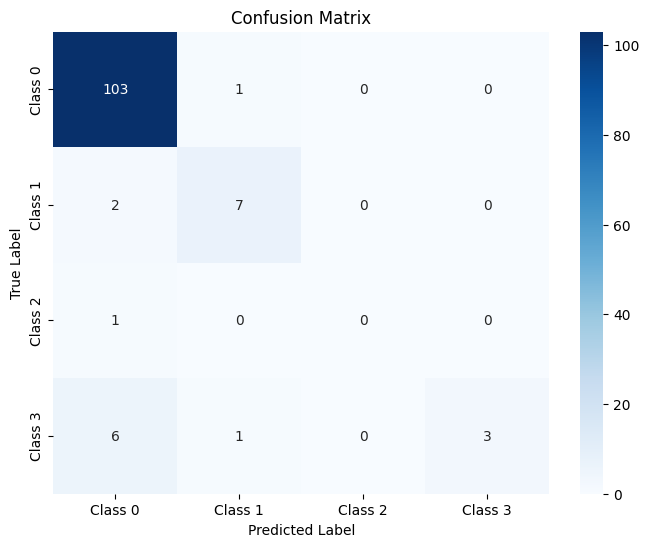

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_validate, predictions)

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [217]:
import joblib

#to use the model with high acc
loaded_model=joblib.load('xgboost.pkl')



**HyperParameter Tuning**

In [227]:
import cupy as cp
hyper_params={
    'objective':['multi:softmax'],
    'eval_metric':['logloss'],
	'eta':[0.01,0.1,0.3,0.9],
	'gamma':[0.05,0.1,0.2],
	'max_depth':[3,12],
	'n_estimators':[100,200,300],
    'num_parallel_tree':[3,10,30],
	'subsample':[0.3,0.5,0.8],
	'sampling_method':['uniform','gradient_based'],
	'lambda':[0.1, 0.5 , 1, 5, 7,10],
    'alpha':[0.01,0.05,0.1,0.3,1],
	'tree_method':['hist','approx'],
	'grow_policy':['depthwise','lossguide'],
}
allParams=sorted(hyper_params)

combinations=list(itr.product(*(hyper_params[param] for param in allParams)))


def grid_search_xgb(parameters, X_train, y_train, cv=5):
  """
  Performs grid search with KFold cross-validation for XGBoost with DMatrix.

  Args:
      params: Dictionary of hyperparameter grids to search over.
      x_train: DMatrix containing training data features.
      y_train: Training data target labels.
      cv: Number of folds for KFold cross-validation (default=5).
      scoring: Evaluation metric for scoring models (default='neg_mean_squared_error').
      eval_metric: Evaluation metric reported during training (default='rmse').

  Returns:
      best_params: Dictionary containing the best hyperparameters found.
      best_model: The XGBoost model with the best hyperparameters.
      cv_results: Dictionary containing cross-validation results for each parameter combination.
  """

  best_params = None
  best_score = float('-inf') 
  cv_results = {}


  kfold = KFold(n_splits=cv, shuffle=True)

  for combination in parameters:
    for train_idx, val_idx in kfold.split(X_train, y_train):
      x_train_fold = X_train.iloc[train_idx]
      x_val_fold = X_train.iloc[val_idx]
      y_train_fold = y_train[train_idx]
      y_val_fold = y_train[val_idx]


      train_dmatrix = xgb.DMatrix(x_train_fold, label=y_train_fold)
      val_dmatrix = xgb.DMatrix(x_val_fold, label=y_val_fold)

      params = {
          'num_class': 4,
          'alpha': combination[0],
          'device': 'cuda',
          'eta': combination[1],
          'eval_metric': 'logloss',
          'gamma': combination[3],
          'grow_policy': combination[4],
          'lambda': combination[5],
          'max_depth': combination[6],
          'num_parallel_tree': combination[8],
          'objective': 'multi:softmax',
          'sampling_method': combination[10],
          'subsample': combination[11],
          'tree_method': combination[12],
      }


      model = xgb.train(params, train_dmatrix,
                  num_boost_round=200)

      #eval_results = model.eval(val_dmatrix, name='validation')
      #validation_score = eval_results['validation']['logloss']

      predictions=model.predict(val_dmatrix)
      accuracy=accuracy_score(y_val_fold, predictions)
      print(f'accuracy score ={accuracy} for the following params:{params}')

      if accuracy > best_score:
        best_score = accuracy
        best_params = combination
        best_model = model

      if combination not in cv_results:
        cv_results[combination] = []
      cv_results[combination].append(accuracy)

  return best_params, best_model, cv_results


best_params, best_model, cv_results = grid_search_xgb(combinations, X_train, y_train)

# Access results
print(f"Best Hyperparameters: {best_params}")
print(f"Best Model Score: {cv_results}")

accuracy score =0.9924433249370277 for the following params:{'num_class': 4, 'alpha': 0.01, 'device': 'cuda', 'eta': 0.01, 'eval_metric': 'logloss', 'gamma': 0.05, 'grow_policy': 'depthwise', 'lambda': 0.1, 'max_depth': 3, 'num_parallel_tree': 3, 'objective': 'multi:softmax', 'sampling_method': 'uniform', 'subsample': 0.3, 'tree_method': 'hist'}
accuracy score =0.9748110831234257 for the following params:{'num_class': 4, 'alpha': 0.01, 'device': 'cuda', 'eta': 0.01, 'eval_metric': 'logloss', 'gamma': 0.05, 'grow_policy': 'depthwise', 'lambda': 0.1, 'max_depth': 3, 'num_parallel_tree': 3, 'objective': 'multi:softmax', 'sampling_method': 'uniform', 'subsample': 0.3, 'tree_method': 'hist'}
accuracy score =0.9748110831234257 for the following params:{'num_class': 4, 'alpha': 0.01, 'device': 'cuda', 'eta': 0.01, 'eval_metric': 'logloss', 'gamma': 0.05, 'grow_policy': 'depthwise', 'lambda': 0.1, 'max_depth': 3, 'num_parallel_tree': 3, 'objective': 'multi:softmax', 'sampling_method': 'uniform

KeyboardInterrupt: 